In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
sys.path.append('../')
from model.erroneousChoice_full import  erroneousChoice
from kernel import jaxrbf
from utility import  paramz
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)     

# Learning from choice data

We illustrate the overall model with an example. We consider the bi-dimensional utility function ${\bf u}(x)=[\cos(2x),-sin(2 x)]$ with $x \in \mathbb{R}$. 

We use ${\bf u}$ to define a choice function. For instance, consider the set of options $A_k=\{0,0.5,2.36\}$, given that ${\bf u}( 0)=[1,0]$, ${\bf u}(0.5)=[0.54,-0.84]$, $
{\bf u}( 2.36)=[0,1]$,
we have that $C(A_k)=\{0,2.36\}$ and $R(A_k)=A_k \backslash C(A_k)=\{0.5\}$. In fact, one can notice that  $[1,0]$ dominates  $[0.54,-0.84]$ on both the utilities, and $[1,0]$  and $[0,1]$ are incomparable.  We sample $200$ inputs $x_i$ at random in $[-4.5,4.5]$ and, using the above approach, we generate a dataset 
of $m=150$ random subsets $\{A_k\}_{k=1}^m$ of the 200 points each one of size $|A_k|=3$  and computed the corresponding choice pairs $(C(A_k),A_k)$ based on  ${\bf u}$.

Note that, we use botorch (and torch) only to build the dataset (in particular we use the function `is_non_dominated`). For ChoiceGP, we instead use `jax` for automatic differentiation.

In [3]:
import torch
from botorch.utils.multi_objective import is_non_dominated
def is_pareto(X):
    return is_non_dominated(torch.from_numpy(X),deduplicate=False)

#generate CA RA sets
def make_CA_RA(x, y, rows=[]):
    if len(rows)==0:
        rows=np.arange(x.shape[0])
    acc = rows[is_pareto(y)]
    rej = rows[~ is_pareto(y)]
    return acc, rej

def make_observations(X, fun, nA, dimA):
    CA=[]
    RA=[]   
    ix = 0
    for i in range(nA):
        rows = np.random.permutation(np.arange(X.shape[0]))[0:dimA]
        x=X[rows,:]
        y=fun(x)
        acc,rej=make_CA_RA(x, y, rows)
        if len(acc)>0:
            CA.append(acc)
        else:
            CA.append([])
        if len(acc)<dimA:
            RA.append(rej)
        else:
            RA.append([])
        ix = ix+1
    return CA, RA


#generate data
np.random.seed(1)

bounds=[[-4.5,4.5]]
def fun(x):
    return np.hstack([np.cos(2*x),-np.sin(2*x)]) 

# we randomly generate objects
n = 200 # number of objects
X = np.sort(np.vstack(bounds)[:,0]+np.random.rand(n,1)*(np.vstack(bounds)[:,1]-np.vstack(bounds)[:,0]),axis=0)

# we randomly generate choice data
nA = 150
dimA = 3
CA, RA = make_observations(X, fun, nA, dimA)

# We use this for prediction (plotting)
Xpred=np.linspace(bounds[0][0],bounds[0][1],200)[:,None]

## Fixed latent dimension

The following code allows us to learn a choice function from choice-data. We have to select the latent dimension `latent_dim`, which represents the number of utility functions. Similarly to GP processes for multiclass classification, we model each  latent utility function in the vector ${\bf u}({\bf x})=[u_1({\bf x}),\dots,u_{d}({\bf x})]^\top$ as an independent GP:
$$
 u_i({\bf x}) \sim \text{GP}_i(0,k_i({\bf x},{\bf x}')), ~~~~i=1,2,\dots,d.
$$
 Each GP is fully specified by its kernel function $k_i(\cdot,\cdot)$, which defines the covariance of the latent function between any two points. The model parameters are the kernel parameters (lengthscales) in $k_i(\cdot,\cdot)$, and the variance. These parameters must be initiliased and then they are optimised using variational inference.

In [4]:
#choice data
data={'X': X,#objects
      'CA': CA,#choiced objects
      'RA': RA,#rejected objects
      'dimA':dimA# dimension of the choice set
          }

# number of latent utilities
latent_dim=2

# define kernel 
Kernel = jaxrbf.RBF
#hyperparameters of the kernel
params = {'lengthscale_0': {'value':1.0*np.ones(data["X"].shape[1],float), 
                            'range':np.vstack([[0.1, 3.0]]*data["X"].shape[1]),
                            'transform': paramz.logexp()},
                 'variance_0': {'value':np.array([3]), 
                            'range':np.vstack([[1.0, 200.0]]),
                            'transform': paramz.logexp()},
          'lengthscale_1': {'value':1.0*np.ones(data["X"].shape[1],float), 
                            'range':np.vstack([[0.1, 3.0]]*data["X"].shape[1]),
                            'transform': paramz.logexp()},
                 'variance_1': {'value':np.array([3]), 
                            'range':np.vstack([[1.0, 200.0]]),
                            'transform': paramz.logexp()}
              }

# define choice model 
model = erroneousChoice(data,Kernel,params,latent_dim)
# compute variational inference and estimate hyperparameters
model.optimize_hyperparams(niterations=500,kernel_hypers_fixed=False)
print(model.params)
# predicted samples
predictions = model.predict_VI(Xpred)
#it returns the joint mean (predictions[0]) and joint covariance matrix (predictions[1]) for the latent utilities. They have

313622.6289356658
668130.0369432924
148.43667328125846
148.2948528366333
148.29485708261373
148.36509167109546
148.29485283669126
455989.10083315044
148.29485283651275


  0%|          | 0/500 [00:00<?, ?it/s]

148.29490238431376
148.29485283651275


 lower bound 207.84868773221802:  36%|███▌      | 178/500 [01:15<01:56,  2.77it/s]

KeyboardInterrupt: 

<ipython-input-8-bdc9477dcbe7>:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  cred_int1 = az.hdi(samples1)
<ipython-input-8-bdc9477dcbe7>:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  cred_int2 = az.hdi(samples2)


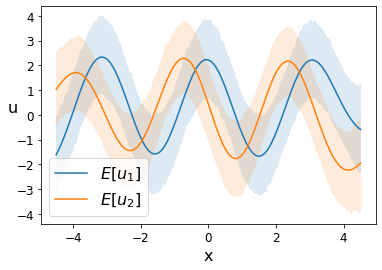

In [8]:
import arviz as az
from scipy.stats import multivariate_normal
ff = predictions[0]
#first utility
mean1=ff[0:Xpred.shape[0]]
#std1=np.sqrt(np.diag(predictions[1][0:Xpred.shape[0],0:Xpred.shape[0]]))
Sigma1 = predictions[1][0:Xpred.shape[0],0:Xpred.shape[0]]
samples1 = multivariate_normal(mean1[:,0],Sigma1+1e-2*np.eye(Sigma1.shape[0])).rvs(4000)
cred_int1 = az.hdi(samples1)
#second utility
mean2=ff[Xpred.shape[0]:]
#std2=np.sqrt(np.diag(predictions[1][Xpred.shape[0]:,Xpred.shape[0]:]))
Sigma2 = predictions[1][Xpred.shape[0]:,Xpred.shape[0]:]
samples2 = multivariate_normal(mean2[:,0],Sigma2+1e-2*np.eye(Sigma2.shape[0])).rvs(4000)
cred_int2 = az.hdi(samples2)

plt.plot(Xpred[:,0],mean1,color='C0',label="$E[u_1]$")
plt.fill_between(Xpred[:,0],cred_int1[:,0],cred_int1[:,1],color='C0', linestyle=':',alpha=0.15)
plt.plot(Xpred[:,0],mean2,color='C1',label="$E[u_2]$")
plt.fill_between(Xpred[:,0],cred_int2[:,0],cred_int2[:,1],color='C1', linestyle=':',alpha=0.15)
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16, rotation=0)
plt.legend(fontsize=16,loc='lower left')

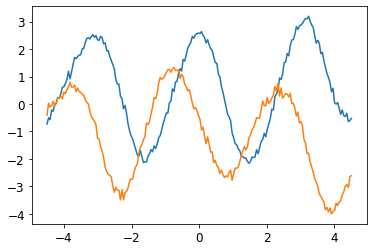

In [18]:
import arviz as az
from scipy.stats import multivariate_normal
mean = predictions[0]
Sigma = predictions[1]
#first utility
samples = multivariate_normal(mean[:,0],Sigma+1e-2*np.eye(Sigma.shape[0])).rvs(4000)
i = 5
u1 = samples[i][0:Xpred.shape[0]]
u2 = samples[i][Xpred.shape[0]:]
plt.plot(Xpred[:,0],u1,color='C0',label="$E[u_1]$")
plt.plot(Xpred[:,0],u2,color='C1',label="$E[u_1]$")

In [ ]:
## Elliptical slice sampler


In [6]:
model.sample()
samples=model.predict(Xpred)


100%|██████████| 8000/8000 [09:58<00:00, 13.36it/s]


In [8]:
samples1.shape

(200, 2000)

<ipython-input-16-e03681179876>:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  cred_int1 = az.hdi(np.array(samples1).T)
<ipython-input-16-e03681179876>:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  cred_int2 = az.hdi(np.array(samples2).T)


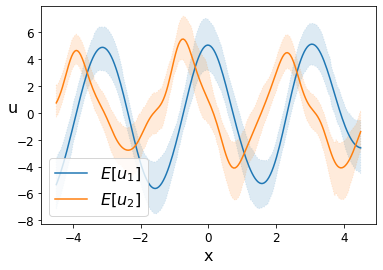

In [16]:
#first utility
samples1 = samples[0:Xpred.shape[0]]
mean1=np.mean(samples1,axis=1)
cred_int1 = az.hdi(np.array(samples1).T)
#second utility
samples2 = samples[Xpred.shape[0]:]
mean2=np.mean(samples2,axis=1)
cred_int2 = az.hdi(np.array(samples2).T)

plt.plot(Xpred[:,0],mean1,color='C0',label="$E[u_1]$")
plt.fill_between(Xpred[:,0],cred_int1[:,0],cred_int1[:,1],color='C0', linestyle=':',alpha=0.15)
plt.plot(Xpred[:,0],mean2,color='C1',label="$E[u_2]$")
plt.fill_between(Xpred[:,0],cred_int2[:,0],cred_int2[:,1],color='C1', linestyle=':',alpha=0.15)
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16, rotation=0)
plt.legend(fontsize=16,loc='lower left')

In [12]:
az.hdi(np.array(samples1))

<ipython-input-12-d2ecd5bafdb2>:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  az.hdi(np.array(samples1))


array([[-4.89675804,  4.67598879],
       [-5.36734098,  4.13668907],
       [-4.89955392,  4.39271634],
       ...,
       [-5.56079353,  5.260501  ],
       [-6.42922313,  4.83443967],
       [-6.41792165,  4.77924618]])

## Learning the latent dimension
To learn the latent dimension, we will use the PSIS-LOO. We will try all values of the latent dimension between 1 and 4 and select the value which has lowest PSIS-LOO.

In [10]:
import model_selection as ms

Scores=ms.model_Selection(X,dimA,  CA_tr=CA, RA_tr=RA, minm=1,maxm=4)
Scores

101591.31818851492
3148.015245903669
300764.8702469492
3147.6691817975416


  0%|          | 0/3000 [00:00<?, ?it/s]

3147.6689110514226
3147.6689110514226


100%|██████████| 3000/3000 [01:48<00:00, 27.75it/s]


(4000, 150)
score= -3145.7180146988094
accuracy train= 0.30666666666666664
  latentdim accuracy_train          loo accuracy_test
0       1.0       0.306667 -3145.718015           NaN


/home/benavoli/Dropbox/DropBoxRunning/SkewNormal_all/SkewNormal/ChoiceLearning/github_code/notebooks/model_selection.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Scores = Scores.append({'latentdim': latentd, 'accuracy_train': acc_tr,  'loo': loo, 'accuracy_test':acc_te}, ignore_index=True)


101.21042411640651
101.16944468624246
551639.7326480777
101.18777224275266


  0%|          | 0/3000 [00:00<?, ?it/s]

101.20328349335006
101.16944468624246


100%|██████████| 3000/3000 [04:46<00:00, 10.46it/s]


(4000, 150)
score= -86.23673925925472
accuracy train= 0.9266666666666666
  latentdim accuracy_train          loo accuracy_test
0       1.0       0.306667 -3145.718015           NaN
1       2.0       0.926667   -86.236739           NaN


/home/benavoli/Dropbox/DropBoxRunning/SkewNormal_all/SkewNormal/ChoiceLearning/github_code/notebooks/model_selection.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Scores = Scores.append({'latentdim': latentd, 'accuracy_train': acc_tr,  'loo': loo, 'accuracy_test':acc_te}, ignore_index=True)


479363.4385647573
114.42296813491552
112.9520351709229
112.8312211851067


  0%|          | 0/3000 [00:00<?, ?it/s]

112.81920039539624
112.81920039539624


100%|██████████| 3000/3000 [08:48<00:00,  5.68it/s]


(4000, 150)
score= -106.19431955100741
accuracy train= 0.92
  latentdim accuracy_train          loo accuracy_test
0       1.0       0.306667 -3145.718015           NaN
1       2.0       0.926667   -86.236739           NaN
2       3.0           0.92   -106.19432           NaN


/home/benavoli/Dropbox/DropBoxRunning/SkewNormal_all/SkewNormal/ChoiceLearning/github_code/notebooks/model_selection.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Scores = Scores.append({'latentdim': latentd, 'accuracy_train': acc_tr,  'loo': loo, 'accuracy_test':acc_te}, ignore_index=True)


1284269.2591012483
129.50850285512922
103103.14536458952
129.59266443441885


  0%|          | 0/3000 [00:00<?, ?it/s]

917408.5887169528
129.50850285512922


100%|██████████| 3000/3000 [13:01<00:00,  3.84it/s]


(4000, 150)
score= -127.8036605822002
accuracy train= 0.88
  latentdim accuracy_train          loo accuracy_test
0       1.0       0.306667 -3145.718015           NaN
1       2.0       0.926667   -86.236739           NaN
2       3.0           0.92   -106.19432           NaN
3       4.0           0.88  -127.803661           NaN


/home/benavoli/Dropbox/DropBoxRunning/SkewNormal_all/SkewNormal/ChoiceLearning/github_code/notebooks/model_selection.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Scores = Scores.append({'latentdim': latentd, 'accuracy_train': acc_tr,  'loo': loo, 'accuracy_test':acc_te}, ignore_index=True)


,latentdim,accuracy_train,loo,accuracy_test
0,1.0,0.306667,-3145.718015,NaN
1,2.0,0.926667,-86.236739,NaN
2,3.0,0.92,-106.19432,NaN
3,4.0,0.88,-127.803661,NaN


The best dimension is $2$, equal to the true dimension.